# 레이블 부족 문제 다루기

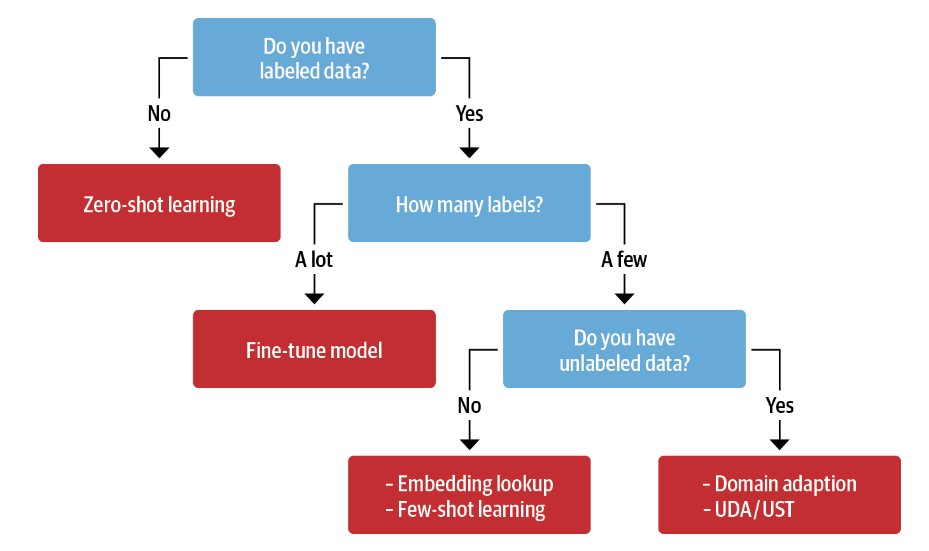

## 1. 깃허브 이슈 태커 만들기
- 깃허브 이슈는 제목, 설명, 이슈의 특징을 나타내는 일련의 태그 또는 레이블을 담고 있어 자연스럽게 지도학습 작업으로 구성할 수 있다.
- 이슈의 제목과 설명이 주어지면 한 개 이상의 레이블을 예측하는 식이다.
- 이슈에 여러 개의 레이블을 할당할 수 있으므로 다중 레이블 텍스트 분류 문제가 된다.
- 이 문제는 각 트윗에 하나의 감정만 할당하는 다중 분류 문제보다 더 어렵다.

### 1) 데이터 다운로드하기
- 젖아소의 이슈를 모두 다운로드 하려면 깃허브 REST API에 있는 Issues 엔드포인트를 반복해 호출해야 한다.
- 이 엔드 포인트는 JSON 객체의 리스트를 반환합니다.
- 이 객체는 이슈 상태와 이슈를 생성한 사람은 물론이고 제목, 본문, 레이블 등에 해당 이슈에 괂나 많은 필드를 포함합니다.
- 모든 이슈를 다운로드하려면 시간이 걸리므로 이 책의 깃허브 저장소에 미리 github-issues-transformers.json 파일을 준비해뒀습니다.
- 직접 다운로드하고 싶다면 9장 노트북의 fetch_issues()함수를 사용하세요

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=9)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/kaggle/working/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.1.0
Using nlpaug v1.1.11
Using skmultilearn
Using sacremoses v0.0.41


In [2]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기 : {df_issues.shape}")

데이터프레임 크기 : (9930, 26)


In [3]:
cols = ['url','id','title','user','labels','state','created_at','body']
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [5]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [6]:
df_issues['labels'].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블을 출력합니다.
df_counts.to_frame().head(8).T

레이블 개수: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [10]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues['labels'] = df_issues['labels'].apply(filter_labels)
all_labels = list(label_map.values())

In [11]:
df_counts = df_issues['labels'].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [12]:
df_issues['split'] = 'unlabeled'
mask = df_issues['labels'].apply(lambda x: len(x)) > 0
df_issues.loc[mask, 'split'] = 'labeled'
df_issues['split'].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [13]:
for column in ['title','body','labels']:
    print(f"{column}:{df_issues[column].iloc[26][:500]}\n")

title:Add new CANINE model

body:# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels:['new model']



In [14]:
df_issues['text'] = (df_issues.apply(lambda x:x['title'] + '\n\n' + x['body'], axis=1))

In [15]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset='text')
print(f"삭제된 중복 이슈 : {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈 : 1.88%


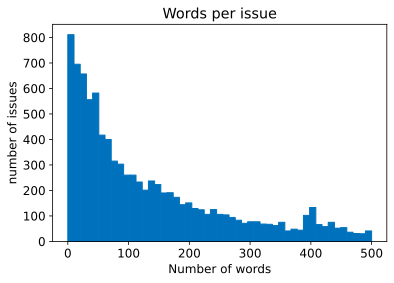

In [17]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues['text'].str.split().apply(len).hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("number of issues")
plt.show()

- 이 분포에는 많은 텍스트 데이터셋에서 보이는 롱테일 특징이 있다.
- 대부분의 텍스트가 매우 짧지만 500단어가 넘는 이슈도 있다.
- 특히 여러 메시지나 코드를 함께 포스팅하면 보통 이슈의 길이가 커집니다.
- 대부분의 트랜스포머 모델의 문맥 크기는 512개 토큰이나
- 그 이상이기 때문에 일부 긴 이슈를 잘라내는 것이 전테 성능에 영향을 미칠 것 같지 않습니다.
- 데이터셋을 살펴보고 정제했으나, 마지막으로 훈련 세트와 분류기를 평가할 검증 세트를 정의하겠습니다.

### 3) 훈련 세트 만들기
- 다중 레이블 문제에서는 훈련 세트와 검증 세트를 만들기가 까다롭다.
- 이때 모든 레이블에 대해 균형 잡힌 비율을 보장하지 못하기 때문이다.
- 하지만 이런 목적을 위해 틀별히 갭라된 scikit-multilearn 라이브러리를 사용하면 도움이 된다.
- 먼저 pytorch와 tokenization 같은 레이블을 모델이 처리가능한 포맷을 변환합니다.
- 이를 위해 사이킷런의 MultiLabelBinarizer 클래스를 사용한다.
- 이 클래스는 레이블 이름의 리스트를 받고 레이블에 해당하는 위치는 1, 나머지는 0인 벡터를 만든다.
- 다음처럼 레이블 이름을 ID로 매핑하기 위해 all_labels리스트에 MultiLabelBinarizer 클래스를 적용해보자

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([['tokenization','new model'], ['pytorch']])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

- 앞의 예에서 첫 번째 행은 두 개의 1을 포함하는데
- 각각 new model과 tokenization 레이블에 해당합니다.
- 두번째 행은 pytorch 하나만 1입니다.


- scikit=multilearn의 iterative_train_test_split()함수를 사용해 이 데이터셋을 분할합니다.
- 이 함수는 레이블의 균형을 잡기 위해 반복적으로 훈련/테스트 세트를 만듭니다.
- 이 함수를 DataFrame에 적용하기 위해 별도의 함수로 감싸겠습니다.
- 이 함수는 2차원 특성 행렬을 기대하므로 분할하기 전에 인덱스 배열에 차원을 추가합니다.

In [22]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [23]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [25]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    'train' : Dataset.from_pandas(df_train.reset_index(drop=True)),
    'valid' : Dataset.from_pandas(df_valid.reset_index(drop=True)),
    'test' : Dataset.from_pandas(df_test.reset_index(drop=True)),
    'unsup' : Dataset.from_pandas(df_unsup.reset_index(drop=True))
})

### 4) 훈련 슬라이스 만들기
- 이 데이터셋은 두 특징이 있다.
- 훈련 세트는 단 220개 샘플로 구성됐으며 전이 학습으로도 확실히 어려운 문제이다.
- 이 장에서 소개하는 각 방법이 적은 양의 레이블링된 데이터에서 얼마나 좋은 성능을 내는지 확인하기 위해 샘플 개수가 더 적은 훈련 데이터의 슬라이스도 만들겠다.
- 그 다음 샘플 개수에 대한 성능을 그래프로 그려서 여러 방법을 분석하겠다.
- iterative_train_test_split() 함수를 사용해야 레이블마다 여덟 개 샘플로 시작해서 전체 훈련 세트를 담은 슬라이스까지 만들겠다.

In [26]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 마지막 슬라이스를 포함하면 코랩의 경우 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 다음 라인을 주석 처리하세요.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [27]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]
